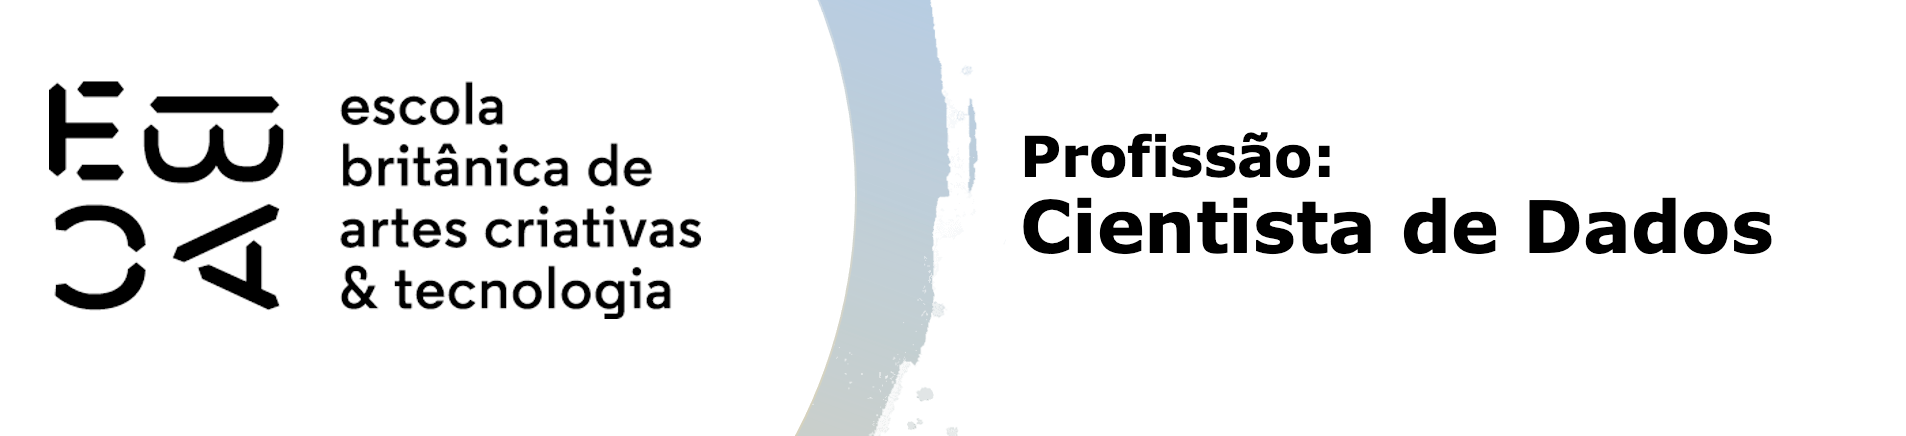

# Tarefa I

Neste projeto, estamos construindo um credit scoring para cartão de crédito, em um desenho amostral com 15 safras, e utilizando 12 meses de performance.

Carregue a base de dados ```credit_scoring.ftr```.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import ks_2samp
from pycaret.classification import *
from sklearn.compose import ColumnTransformer

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_feather('./input/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [3]:
print(df.columns)

Index(['data_ref', 'index', 'sexo', 'posse_de_veiculo', 'posse_de_imovel',
       'qtd_filhos', 'tipo_renda', 'educacao', 'estado_civil',
       'tipo_residencia', 'idade', 'tempo_emprego', 'qt_pessoas_residencia',
       'renda', 'mau'],
      dtype='object')


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   data_ref               750000 non-null  datetime64[ns]
 1   index                  750000 non-null  int64         
 2   sexo                   750000 non-null  object        
 3   posse_de_veiculo       750000 non-null  object        
 4   posse_de_imovel        750000 non-null  object        
 5   qtd_filhos             750000 non-null  int64         
 6   tipo_renda             750000 non-null  object        
 7   educacao               750000 non-null  object        
 8   estado_civil           750000 non-null  object        
 9   tipo_residencia        750000 non-null  object        
 10  idade                  750000 non-null  int64         
 11  tempo_emprego          624043 non-null  float64       
 12  qt_pessoas_residencia  750000 non-null  floa

## Amostragem

Separe os três últimos meses como safras de validação *out of time* (oot).

Variáveis:<br>
Considere que a variável ```data_ref``` não é uma variável explicativa, é somente uma variável indicadora da safra, e não deve ser utilizada na modelagem. A variávei ```index``` é um identificador do cliente, e também não deve ser utilizada como covariável (variável explicativa). As restantes podem ser utilizadas para prever a inadimplência, incluindo a renda.


In [5]:
print(df.data_ref.min())
print(df.data_ref.max())

2015-01-01 00:00:00
2016-03-01 00:00:00


In [6]:
df["data_ref"] = pd.to_datetime(df["data_ref"])

ultimos_tres_meses = df["data_ref"].sort_values().unique()[-3:]

df_oot = df[df["data_ref"].isin(ultimos_tres_meses)]
df_treino = df[~df["data_ref"].isin(ultimos_tres_meses)]

print(f"Conjunto de treino: {df_treino.shape}")
print(f"Conjunto de validação OOT: {df_oot.shape}")

Conjunto de treino: (600000, 15)
Conjunto de validação OOT: (150000, 15)


## Descritiva básica univariada

- Descreva a base quanto ao número de linhas, número de linhas para cada mês em ```data_ref```.
- Faça uma descritiva básica univariada de cada variável. Considere as naturezas diferentes: qualitativas e quantitativas.

In [7]:
num_linhas_total = df.shape[0]

linhas_por_mes = df["data_ref"].value_counts().sort_index()

print(f"Número total de linhas: {num_linhas_total}")
print("\nNúmero de linhas por mês:")
print(linhas_por_mes)

Número total de linhas: 750000

Número de linhas por mês:
data_ref
2015-01-01    50000
2015-02-01    50000
2015-03-01    50000
2015-04-01    50000
2015-05-01    50000
2015-06-01    50000
2015-07-01    50000
2015-08-01    50000
2015-09-01    50000
2015-10-01    50000
2015-11-01    50000
2015-12-01    50000
2016-01-01    50000
2016-02-01    50000
2016-03-01    50000
Name: count, dtype: int64


In [8]:
variaveis_qualitativas = df.select_dtypes(include=["object", "bool"]).columns.tolist()
variaveis_quantitativas = df.select_dtypes(include=["int64", "float64"]).columns.tolist()

if "index" in variaveis_quantitativas:
    variaveis_quantitativas.remove("index")
if "data_ref" in variaveis_quantitativas:
    variaveis_quantitativas.remove("data_ref")

descr_qualitativas = {var: df[var].value_counts() for var in variaveis_qualitativas}

descr_quantitativas = df[variaveis_quantitativas].describe()

print("\nAnálise descritiva das variáveis qualitativas:")
for var, dist in descr_qualitativas.items():
    print(f"\n{var}:")
    print(dist)

print("\nAnálise descritiva das variáveis quantitativas:")
print(descr_quantitativas)


Análise descritiva das variáveis qualitativas:

sexo:
sexo
F    504580
M    245420
Name: count, dtype: int64

posse_de_veiculo:
posse_de_veiculo
N    457954
S    292046
Name: count, dtype: int64

posse_de_imovel:
posse_de_imovel
S    503692
N    246308
Name: count, dtype: int64

tipo_renda:
tipo_renda
Assalariado         385740
Empresário          172712
Pensionista         126265
Servidor público     64922
Bolsista               361
Name: count, dtype: int64

educacao:
educacao
Médio                  506836
Superior completo      204306
Superior incompleto     29471
Fundamental              8575
Pós graduação             812
Name: count, dtype: int64

estado_civil:
estado_civil
Casado      526472
Solteiro     91659
União        57685
Separado     42571
Viúvo        31613
Name: count, dtype: int64

tipo_residencia:
tipo_residencia
Casa             674294
Com os pais       33232
Governamental     23440
Aluguel           10349
Estúdio            5395
Comunitário        3290
Name: count,

## Descritiva bivariada

Faça uma análise descritiva bivariada de cada variável


Análise bivariada:

sexo vs mau:
mau      False     True 
sexo                    
F     0.919478  0.080522
M     0.926603  0.073397

posse_de_veiculo vs mau:
mau                  False     True 
posse_de_veiculo                    
N                 0.921210  0.078790
S                 0.922748  0.077252

posse_de_imovel vs mau:
mau                 False     True 
posse_de_imovel                    
N                0.911521  0.088479
S                0.926840  0.073160

tipo_renda vs mau:
mau                  False     True 
tipo_renda                          
Assalariado       0.919083  0.080917
Bolsista          0.958449  0.041551
Empresário        0.923549  0.076451
Pensionista       0.917317  0.082683
Servidor público  0.941915  0.058085

educacao vs mau:
mau                     False     True 
educacao                               
Fundamental          0.908338  0.091662
Médio                0.919639  0.080361
Pós graduação        0.927340  0.072660
Superior completo    0.928

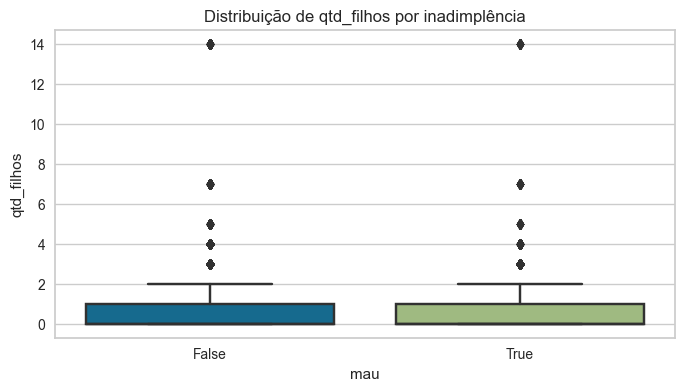

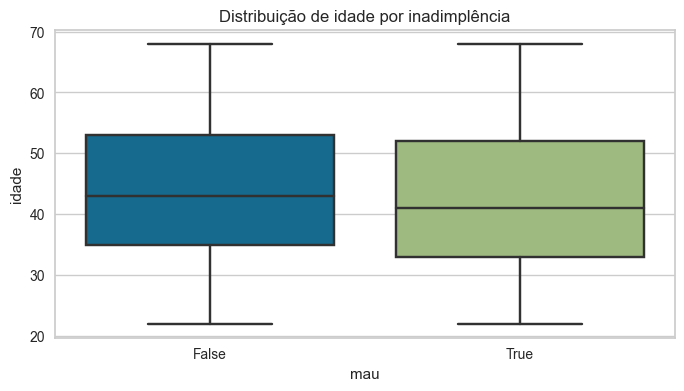

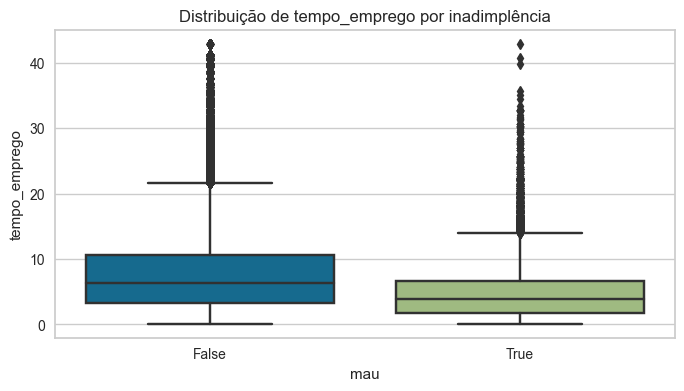

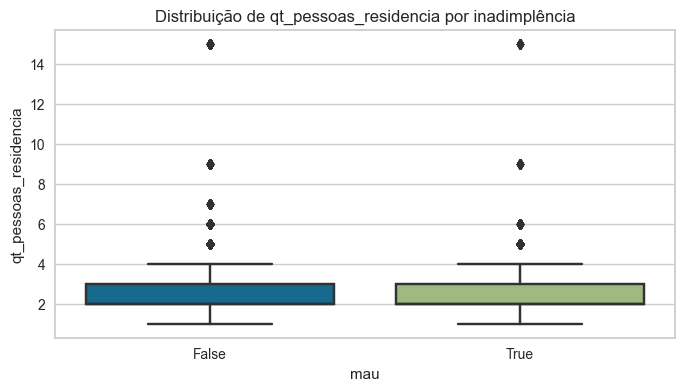

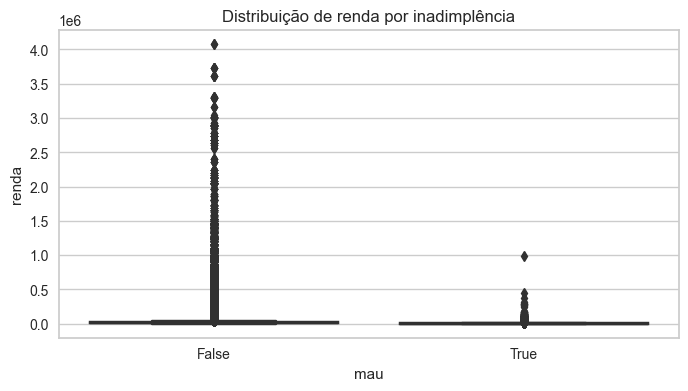

In [9]:
print("\nAnálise bivariada:")

for var in variaveis_qualitativas:
    print(f"\n{var} vs mau:")
    print(pd.crosstab(df[var], df["mau"], normalize="index"))

for var in variaveis_quantitativas:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df["mau"], y=df[var])
    plt.title(f"Distribuição de {var} por inadimplência")
    plt.show()

## Desenvolvimento do modelo

Desenvolva um modelo de *credit scoring* através de uma regressão logística.

- Trate valores missings e outliers
- Trate 'zeros estruturais'
- Faça agrupamentos de categorias conforme vimos em aula
- Proponha uma equação preditiva para 'mau'
- Caso hajam categorias não significantes, justifique

In [10]:
for col in df_treino.select_dtypes(include=["int64", "float64"]):
    df_treino[col].fillna(df_treino[col].median(), inplace=True)
    df_oot[col].fillna(df_treino[col].median(), inplace=True)

for col in df_treino.select_dtypes(include=["object", "bool"]):
    df_treino[col].fillna(df_treino[col].mode()[0], inplace=True)
    df_oot[col].fillna(df_treino[col].mode()[0], inplace=True)

In [11]:
for col in df_treino.select_dtypes(include=["int64", "float64"]):
    Q1 = df_treino[col].quantile(0.25)
    Q3 = df_treino[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df_treino[col] = np.clip(df_treino[col], lower_bound, upper_bound)
    df_oot[col] = np.clip(df_oot[col], lower_bound, upper_bound)

In [12]:
if 'renda' in df_treino.columns:
    mediana_renda = df_treino.loc[df_treino["renda"] > 0, "renda"].median()
    df_treino.loc[df_treino["renda"] == 0, "renda"] = mediana_renda
    df_oot.loc[df_oot["renda"] == 0, "renda"] = mediana_renda

In [13]:
categorical_cols = df_treino.select_dtypes(include=["object", "category"]).columns

limite_frequencia = 100

for col in categorical_cols:
    categorias_frequentes = df_treino[col].value_counts()
    categorias_frequentes = categorias_frequentes[categorias_frequentes >= limite_frequencia].index

    df_treino[col] = df_treino[col].apply(lambda x: x if x in categorias_frequentes else "Outros")
    df_oot[col] = df_oot[col].apply(lambda x: x if x in categorias_frequentes else "Outros")

print("Agrupamento de categorias realizado com sucesso!")

Agrupamento de categorias realizado com sucesso!


In [14]:
drop_cols = ["index", "data_ref", "mau"]
X_train = df_treino.drop(columns=drop_cols)
y_train = df_treino["mau"]
X_oot = df_oot.drop(columns=drop_cols)
y_oot = df_oot["mau"]

X_train = pd.get_dummies(X_train, drop_first=True)
X_oot = pd.get_dummies(X_oot, drop_first=True)

missing_cols = set(X_train.columns) - set(X_oot.columns)
for col in missing_cols:
    X_oot[col] = 0
X_oot = X_oot[X_train.columns]

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_oot = scaler.transform(X_oot)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_oot)
y_prob = model.predict_proba(X_oot)[:, 1]
print("\nRelatório de Classificação:")
print(classification_report(y_oot, y_pred))
print(f"AUC-ROC Score: {roc_auc_score(y_oot, y_prob):.4f}")


Relatório de Classificação:
              precision    recall  f1-score   support

       False       0.85      1.00      0.92    128000
        True       0.00      0.00      0.00     22000

    accuracy                           0.85    150000
   macro avg       0.43      0.50      0.46    150000
weighted avg       0.73      0.85      0.79    150000

AUC-ROC Score: 0.7273


In [15]:
def mostrar_equacao(model, X_columns):
    coeficientes = model.coef_[0]
    intercepto = model.intercept_[0]
    equacao = "Logit(P) = {:.4f}".format(intercepto)
    for coef, col in zip(coeficientes, X_columns):
        equacao += " + ({:.4f} * {})".format(coef, col)
    print("\nEquação preditiva:")
    print(equacao)

mostrar_equacao(model, df_treino.drop(columns=drop_cols).columns)


Equação preditiva:
Logit(P) = -3.4978 + (0.0030 * sexo) + (0.0041 * posse_de_veiculo) + (-0.0947 * posse_de_imovel) + (-0.0036 * qtd_filhos) + (-1.6863 * tipo_renda) + (-0.0527 * educacao) + (0.0157 * estado_civil) + (-0.0353 * tipo_residencia) + (0.0030 * idade) + (-0.0200 * tempo_emprego) + (-0.0298 * qt_pessoas_residencia) + (-0.0069 * renda)


## Avaliação do modelo

Avalie o poder discriminante do modelo pelo menos avaliando acurácia, KS e Gini.

Avalie estas métricas nas bases de desenvolvimento e *out of time*.

In [16]:
y_train_pred = model.predict(X_train)
y_oot_pred = model.predict(X_oot)

acc_train = accuracy_score(y_train, y_train_pred)
acc_oot = accuracy_score(y_oot, y_oot_pred)

print(f"Acurácia - Treino: {acc_train:.4f}")
print(f"Acurácia - OOT: {acc_oot:.4f}")

Acurácia - Treino: 0.9389
Acurácia - OOT: 0.8533


In [17]:
ks_train = ks_2samp(y_train_pred[y_train == 1], y_train_pred[y_train == 0]).statistic
ks_oot = ks_2samp(y_oot_pred[y_oot == 1], y_oot_pred[y_oot == 0]).statistic

print(f"KS - Treino: {ks_train:.4f}")
print(f"KS - OOT: {ks_oot:.4f}")

KS - Treino: 0.0000
KS - OOT: 0.0000


In [18]:
def gini_score(y_true, y_prob):
    return 2 * roc_auc_score(y_true, y_prob) - 1

gini_train = gini_score(y_train, model.predict_proba(X_train)[:, 1])
gini_oot = gini_score(y_oot, model.predict_proba(X_oot)[:, 1])

print(f"Gini - Treino: {gini_train:.4f}")
print(f"Gini - OOT: {gini_oot:.4f}")

Gini - Treino: 0.5342
Gini - OOT: 0.4546


# a - Criar um pipeline utilizando o sklearn pipeline para o preprocessamento 

## Pré processamento

### Substituição de nulos (nans)

Existe nulos na base? é dado numérico ou categórico? qual o valor de substituição? média? valor mais frequente? etc

In [19]:
df.drop(['data_ref', 'index'], axis=1, inplace=True)

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   sexo                   750000 non-null  object 
 1   posse_de_veiculo       750000 non-null  object 
 2   posse_de_imovel        750000 non-null  object 
 3   qtd_filhos             750000 non-null  int64  
 4   tipo_renda             750000 non-null  object 
 5   educacao               750000 non-null  object 
 6   estado_civil           750000 non-null  object 
 7   tipo_residencia        750000 non-null  object 
 8   idade                  750000 non-null  int64  
 9   tempo_emprego          624043 non-null  float64
 10  qt_pessoas_residencia  750000 non-null  float64
 11  renda                  750000 non-null  float64
 12  mau                    750000 non-null  bool   
dtypes: bool(1), float64(3), int64(2), object(7)
memory usage: 69.4+ MB


In [21]:
df.isnull().sum()

sexo                          0
posse_de_veiculo              0
posse_de_imovel               0
qtd_filhos                    0
tipo_renda                    0
educacao                      0
estado_civil                  0
tipo_residencia               0
idade                         0
tempo_emprego            125957
qt_pessoas_residencia         0
renda                         0
mau                           0
dtype: int64

In [22]:
def verifica_nulos(df):
    for coluna in df.columns:
        if df[coluna].isnull().sum() > 0:
            if df[coluna].dtype in [np.float64, np.int64]:
                df[coluna].fillna(df[coluna].mean(), inplace=True)
            else:
                df.dropna(subset=[coluna], inplace=True)
    return df


verifica_nulos(df)

,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
749995,M,N,S,0,Empresário,Superior completo,Casado,Casa,48,3.038356,2.0,2109.99,False
749996,F,N,S,0,Pensionista,Médio,Solteiro,Casa,65,7.748574,1.0,1389.39,False
749997,M,S,N,2,Assalariado,Médio,Casado,Casa,43,10.375342,4.0,649.06,True
749998,F,N,S,0,Assalariado,Médio,Viúvo,Casa,56,13.780822,1.0,4216.72,True


In [23]:
df.isnull().sum()

sexo                     0
posse_de_veiculo         0
posse_de_imovel          0
qtd_filhos               0
tipo_renda               0
educacao                 0
estado_civil             0
tipo_residencia          0
idade                    0
tempo_emprego            0
qt_pessoas_residencia    0
renda                    0
mau                      0
dtype: int64

> Sim, há nulos. Numéricos substituídos pela média; categóricos pelo valor mais frequente.

### Remoção de outliers

Como identificar outlier? Substituir o outlier por algum valor? Remover a linha?

In [24]:
df.shape

(750000, 13)

In [25]:
class RemoveOutliersIQR(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  

    def transform(self, X):
        X_clean = X.copy()
        for coluna in X_clean.select_dtypes(include=[np.number]).columns:
            q25, q75 = np.percentile(X_clean[coluna], [25, 75])
            coluna_iqr = q75 - q25
            coluna_cut_off = coluna_iqr * 1.5
            coluna_lower, coluna_upper = q25 - coluna_cut_off, q75 + coluna_cut_off
            X_clean = X_clean[(X_clean[coluna] >= coluna_lower) & (X_clean[coluna] <= coluna_upper)]
        return X_clean

> Identificados via Z-Score. Optei por remover as linhas com outliers.

### Seleção de variáveis

Qual tipo de técnica? Boruta? Feature importance? 

In [26]:
class SelecionaVariaveis(BaseEstimator, TransformerMixin):
    def __init__(self, target, n_features=8):
        self.target = target
        self.n_features = n_features
        self.top_features = None

    def fit(self, X, y=None):
        X_encoded = pd.get_dummies(X.drop(columns=[self.target]), drop_first=True)
        y_target = X[self.target]

        model = RandomForestClassifier()
        model.fit(X_encoded, y_target)

        feature_importance = pd.Series(model.feature_importances_, index=X_encoded.columns)
        self.top_features = feature_importance.nlargest(self.n_features).index.tolist()
        
        return self
    
    def transform(self, X):
        X_encoded = pd.get_dummies(X.drop(columns=[self.target]), drop_first=True)
        return X_encoded[self.top_features] if self.top_features else X_encoded

> Usei Feature Importance (Random Forest) e também a seleção automática do PyCaret.

### Redução de dimensionalidade (PCA)

Aplicar PCA para reduzir a dimensionalidade para 5

In [27]:
class AplicarPCA(BaseEstimator, TransformerMixin):
    def __init__(self, n_components=5):
        self.n_components = n_components
        self.pca = PCA(n_components=n_components)

    def fit(self, X, y=None):
        self.pca.fit(X)
        return self
    
    def transform(self, X):
        X_pca = self.pca.transform(X)
        return pd.DataFrame(X_pca, index=X.index, columns=[f'PC{i+1}' for i in range(self.n_components)])

### Criação de dummies

Aplicar o get_dummies() ou onehotencoder() para transformar colunas catégoricas do dataframe em colunas de 0 e 1. 
- sexo
- posse_de_veiculo
- posse_de_imovel
- tipo_renda
- educacao
- estado_civil
- tipo_residencia

In [28]:
df.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [29]:
class OneHotEncodeVeiculo(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        encoder = OneHotEncoder(drop='first', sparse_output=False)
        encoded = encoder.fit_transform(X[['posse_de_veiculo']])
        df_encoded = pd.DataFrame(encoded, columns=['posse_de_veiculo_1'], index=X.index)
        return pd.concat([X.drop(columns=['posse_de_veiculo']), df_encoded], axis=1)

### Pipeline 

Crie um pipeline contendo essas funções.

preprocessamento()
- substituicao de nulos
- remoção outliers
- PCA
- Criação de dummy de pelo menos 1 variável (posse_de_veiculo)

In [30]:
num_features = ['qtd_filhos', 'idade', 'tempo_emprego', 'qt_pessoas_residencia', 'renda']
cat_features = ['sexo', 'posse_de_veiculo', 'posse_de_imovel', 'tipo_renda', 'educacao', 'estado_civil', 'tipo_residencia']

In [31]:
num_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [32]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [33]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ])

In [34]:
full_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('pca', PCA(n_components=5))
])
df_transformado = full_pipeline.fit_transform(df)

In [35]:
df_transformado

array([[-1.23526611e+00, -8.53484362e-01,  6.00682871e-01,
        -9.23945189e-01, -4.76766032e-01],
       [ 1.11626787e-01, -7.38339337e-01,  6.36794408e-01,
         2.86625057e-01,  1.68115639e-01],
       [ 3.15918160e+00,  1.03628799e-04, -5.04746129e-01,
        -1.15212461e+00,  1.40312937e-02],
       ...,
       [ 2.66530752e+00,  1.10053877e+00, -7.62018474e-01,
         1.08397032e+00, -8.16829337e-01],
       [-1.97818809e+00,  1.36467475e-01, -4.77487008e-01,
        -3.89624655e-01, -6.07060597e-01],
       [ 2.65739087e+00,  1.13165008e+00, -7.45282935e-01,
         1.08204212e+00, -7.88419686e-01]])

# b - Pycaret na base de dados 

Utilize o pycaret para pre processar os dados e rodar o modelo **lightgbm**. Faça todos os passos a passos da aula e gere os gráficos finais. E o pipeline de toda a transformação.



In [36]:
df = pd.read_feather('./input/credit_scoring.ftr')
df.head()

,data_ref,index,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau
0,2015-01-01,5733,F,N,N,0,Empresário,Médio,Solteiro,Casa,43,6.873973,1.0,2515.39,False
1,2015-01-01,727,F,S,S,0,Assalariado,Médio,Casado,Casa,35,4.526027,2.0,3180.19,False
2,2015-01-01,6374,F,N,N,2,Assalariado,Médio,Casado,Casa,31,0.243836,4.0,1582.29,False
3,2015-01-01,9566,F,N,N,0,Assalariado,Médio,Casado,Casa,54,12.772603,2.0,13721.17,False
4,2015-01-01,9502,F,S,N,0,Assalariado,Superior incompleto,Solteiro,Casa,31,8.432877,1.0,2891.08,False


In [37]:
dataset = df.sample(50000)
dataset.drop(['data_ref', 'index'], axis=1, inplace=True)

In [38]:
data = dataset.sample(frac=0.95, random_state=786)
data_unseen = dataset.drop(data.index)
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)
print('Conjunto de dados para modelagem (treino e teste): ' + str(data.shape))
print('Conjunto de dados não usados no treino/teste, apenas como validação: ' +
      str(data_unseen.shape))

Conjunto de dados para modelagem (treino e teste): (47500, 13)
Conjunto de dados não usados no treino/teste, apenas como validação: (2500, 13)


In [39]:
clf_setup = setup(data=data, target='mau', session_id=123)

,Description,Value
0,Session id,123
1,Target,mau
2,Target type,Binary
3,Original data shape,"(47500, 13)"
4,Transformed data shape,"(47500, 30)"
5,Transformed train set shape,"(33250, 30)"
6,Transformed test set shape,"(14250, 30)"
7,Numeric features,5
8,Categorical features,7
9,Rows with missing values,16.6%


In [40]:
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


In [41]:
data.dtypes

sexo                      object
posse_de_veiculo          object
posse_de_imovel           object
qtd_filhos                 int64
tipo_renda                object
educacao                  object
estado_civil              object
tipo_residencia           object
idade                      int64
tempo_emprego            float64
qt_pessoas_residencia    float64
renda                    float64
mau                         bool
dtype: object

In [42]:
lgbm = create_model('lightgbm', fix_imbalance=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9209,0.7578,0.0310,0.3810,0.0573,0.0462,0.0904
1,0.9215,0.7450,0.0116,0.3333,0.0225,0.0173,0.0498
2,0.9227,0.7586,0.0310,0.5333,0.0586,0.0505,0.1147
3,0.9215,0.7419,0.0194,0.3846,0.0369,0.0297,0.0719
4,0.9236,0.7600,0.0349,0.6429,0.0662,0.0587,0.1374
5,0.9230,0.7678,0.0271,0.5833,0.0519,0.0453,0.1138
6,0.9230,0.7839,0.0347,0.6000,0.0657,0.0577,0.1311
7,0.9194,0.7764,0.0309,0.3200,0.0563,0.0432,0.0786
8,0.9221,0.7948,0.0309,0.5000,0.0582,0.0496,0.1095


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [43]:
tuned_lgbm = tune_model(lgbm, optimize='F1')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9056,0.7103,0.0581,0.1744,0.0872,0.0504,0.0590
1,0.9038,0.7122,0.0233,0.0811,0.0361,0.0016,0.0020
2,0.9047,0.7231,0.0659,0.1828,0.0969,0.0581,0.0667
3,0.9104,0.7136,0.0659,0.2297,0.1024,0.0702,0.0858
4,0.9122,0.7064,0.0465,0.2069,0.0759,0.0489,0.0644
5,0.9089,0.7076,0.0620,0.2078,0.0955,0.0621,0.0749
6,0.9122,0.7475,0.0656,0.2537,0.1043,0.0747,0.0941
7,0.9020,0.7377,0.0579,0.1546,0.0843,0.0437,0.0496
8,0.9083,0.7547,0.0734,0.2262,0.1108,0.0755,0.0891


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


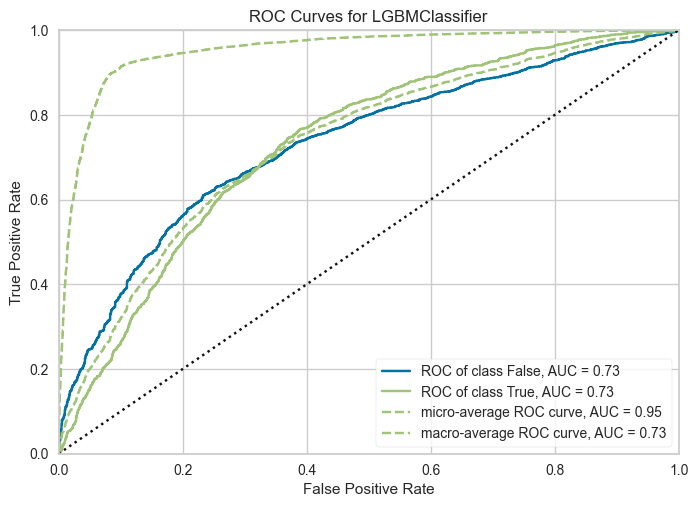

In [44]:
plot_model(tuned_lgbm, plot='auc')

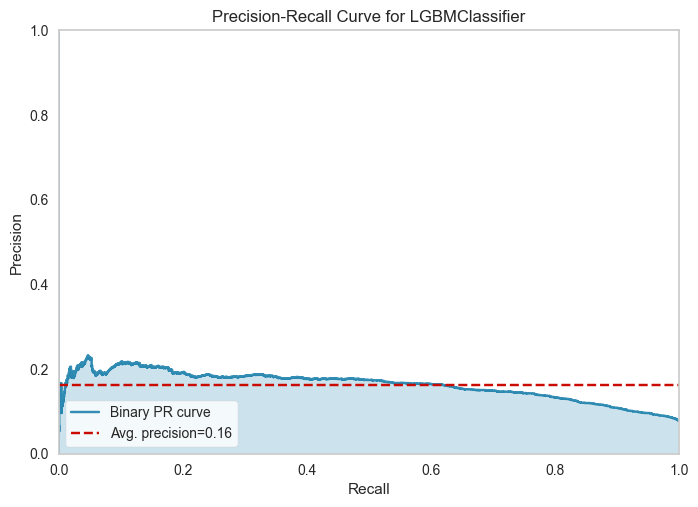

In [45]:
plot_model(tuned_lgbm, plot='pr')

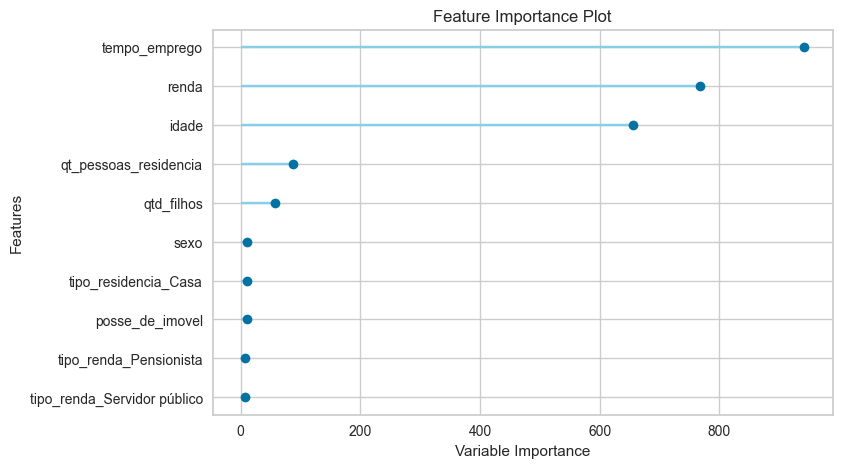

In [46]:
plot_model(tuned_lgbm, plot='feature')

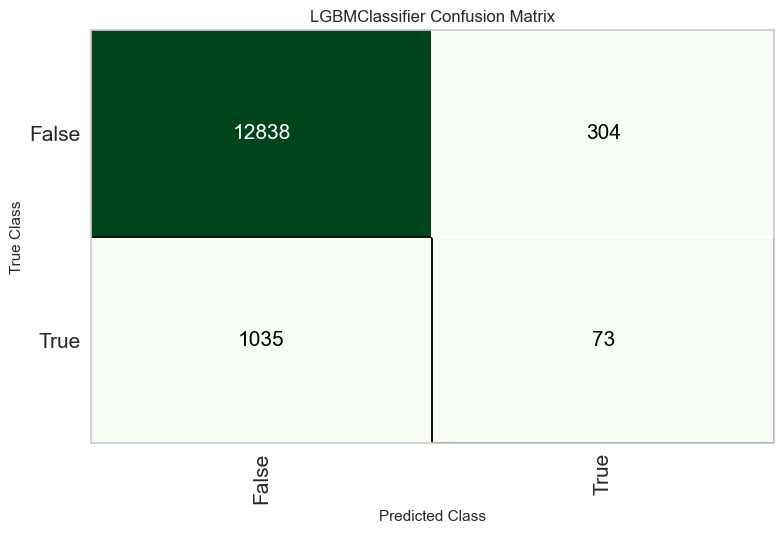

In [47]:
plot_model(tuned_lgbm, plot='confusion_matrix')

In [48]:
predict_model(tuned_lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9060,0.7328,0.0659,0.1936,0.0983,0.0613,0.0713


[LightGBM] [Warning] Unknown parameter: fix_imbalance
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] Unknown parameter: fix_imbalance
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.9, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


,sexo,posse_de_veiculo,posse_de_imovel,qtd_filhos,tipo_renda,educacao,estado_civil,tipo_residencia,idade,tempo_emprego,qt_pessoas_residencia,renda,mau,prediction_label,prediction_score
12281,F,N,N,0,Assalariado,Médio,Casado,Casa,51,5.635616,2.0,5263.399902,False,0,0.9141
16513,M,N,S,1,Assalariado,Fundamental,Casado,Casa,28,4.635616,3.0,5969.879883,False,0,0.9675
44999,M,N,S,0,Pensionista,Superior completo,Casado,Casa,53,NaN,2.0,841.840027,False,0,0.8126
26001,F,N,N,0,Pensionista,Superior completo,União,Casa,56,NaN,2.0,2059.760010,False,0,0.8579
8366,F,N,S,0,Assalariado,Médio,Separado,Casa,53,0.761644,1.0,3153.090088,True,0,0.9202
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11228,M,S,S,0,Empresário,Superior completo,Casado,Casa,42,4.008219,2.0,9739.559570,False,0,0.9724
4793,F,N,S,0,Pensionista,Médio,Casado,Casa,65,NaN,2.0,4798.580078,False,0,0.9345
37628,F,N,S,0,Assalariado,Médio,Casado,Casa,54,0.838356,2.0,2306.870117,False,0,0.8558
27256,F,N,N,0,Pensionista,Médio,Separado,Casa,65,NaN,1.0,1238.400024,False,0,0.8402


In [49]:
final_lgbm = finalize_model(tuned_lgbm)

In [50]:
print(final_lgbm)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['qtd_filhos', 'idade',
                                             'tempo_emprego',
                                             'qt_pessoas_residencia', 'renda'],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='mean'))),
                ('categorical_imputer',
                 TransformerWra...
                                colsample_bytree=1.0, feature_fraction=0.5,
                        

In [51]:
save_model(final_lgbm, 'Final LGBM Model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['qtd_filhos', 'idade',
                                              'tempo_emprego',
                                              'qt_pessoas_residencia', 'renda'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean'))),
                 ('categorical_imputer',
                  TransformerWra...
                                 colsample_bytree=1.0, feature_fraction=0.5,
         